# Discrete Quantum Walks

"Quantum Walk" is an approach for developing and designing quantum algorithms. It can be thought as a quantum analogy to classical random walk. This generic technique underlies many quantum algorithms, in particular, the Grover's search algorithm, can be viewed as a quantum walk.

In similar to classical random walks, quantum walks are divided into the discrete case and the continuos one. This notebook focuses on discrete quantum walks, and is organized as follows: First, we give a [one to one](##Classical-Random-Walks-vs.-Quantum-Walks) comparison between classical random walks and quantum walks, by treating a specific example: a walk on a circle. Then, we define a [general quantum model](##How-to-Build-a-general-Quantum-Walk-with-Classiq) for studying quantum walks, and consequently apply it to the [circle case](##Example:-Symmetric-Quantum-Walk-on-a-Circle) and to a a [hypercube graph](##Example:-4D-Hypercube-with-a-Grover-Coin). 

This tutorial demonstrates the following concepts of Classiq:
* The resemblance between classical and quantum programming with Classiq.
* Classiq's built-in constructs:
    * `control`: general controlled-logic
    *  `power`: "parametric power", specified as execution parameter.
    *  `numeric quantum types`: working with signed and unsigned integers.
    *  `within_apply` : for compute/uncompute operations $U V U^{\dagger}$.
* Passing a list of `QCallables` (quantum functions).
* Parsed execution results, according to quantum variable types.


****

## Classical Random Walks vs. Quantum Walks

We first specify and implement a simple example: a discrete walk on a circle, or more precisely, on a regular polygon having $2^N$ nodes (see Figure 1 below). The idea of random/quantum walk is the following:
1. We start at some initial point, e.g., the zeroth node.
2. We flip a coin, if we get heads/tails we move one step clockwise/counter-clockwise.
3. We repeat steps 1-2 for a given total number of steps $T$.

<center>
<img src="https://docs.classiq.io/resources/circle_random_walk.png" style="width:30%">
<figcaption align = "middle"> Figure 1. A graph for a random walk on a circle. </figcaption>
</center>

In [11]:
import matplotlib.pyplot as plt
import numpy as np

from classiq import *
import classiq
classiq.authenticate()

from qiskit import QuantumCircuit
import sys
sys.path.append('../../../')
from AutomatskiKomencoQiskit import *
sys.path.append('../../')
from AutomatskiClassiq import *

# Run the Circuit using Automatski' Quantum Simulators and Quantum Computers
# No need for transpiling with any transpiler
backend = AutomatskiKomencoQiskit(host="103.212.120.18", port=80)

C:\Users\adityayadav76\.conda\envs\qiskit\Lib\site-packages\classiq\_internals\authentication\token_manager.py:101: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


Let us code a classical random walk and a discrete quantum walk side by side:

First, we define a function to flip a coin:
* Classical: the coin is either 0 or 1, to flip a coin we simply draw a random number from the set $\{0,1\}$.
* Quantum: the coin is represented by a qubit, a "flip" is defined by some unitary operation on it. We choose the Hadamard gate, which sends the $|0\rangle$ state into an equal superposition of $|0\rangle$ and $|1\rangle$.

In [12]:
def classical_coin_flip(coin):
    return np.random.randint(2)


@qfunc
def quantum_coin_flip(coin: QBit):
    H(coin)

Next, we define a function for moving clockwise and counterclockwise. This operation is simply a modular addition by $\pm 1$.
* Classical: the position is an integer in $[-2^{N-1}, 2^{N-1}-1]$, we use basic arithmetic operations.
* Quantum: the position is an $N$-qubits state. We can easily build an inplace modular addition by 1 ourselves (see explanation at [the end of this notebook](#Technical-Notes)). Note that since quantum operations are reversible, we can define a counterclockwise step as the inverse of the clockwise step.

In [13]:
from classiq.qmod.symbolic import pi


# classical
def classical_step_clockwise(x, circle_size):
    return (x + 1) % circle_size


def classical_step_counterclockwise(x, circle_size):
    return (x - 1) % circle_size


# quantum
@qfunc
def quantum_step_clockwise(x: QArray):

    within_apply(
        lambda: qft(x),
        lambda: repeat(x.len, lambda i: PHASE(2 * pi * 2 ** (i) / (2**x.len), x[i])),
    )

Finally, we construct a function for the full walk, iterating over flipping a coin and a single walking step based on the coin's state. Note the difference between the classical and quantum functions' declarations, for the quantum part we do not need to pass the circle size, as it is given by the size of the position state $x$.

In [14]:
# classical


def random_walk_circle(
    time,  # total time
    x,  # position
    circle_size,  # the size of the circle
):
    coin = 0
    for step in range(time):
        coin = classical_coin_flip(coin)
        if coin == 0:
            x = classical_step_clockwise(x, CIRCLE_SIZE)
        if coin == 1:
            x = classical_step_counterclockwise(x, CIRCLE_SIZE)
    return x


# quantum
@qfunc
def discrete_quantum_walk_circle(
    time: CInt,  # total time
    x: QArray[QBit],  # position
):
    coin = QNum("coin")
    allocate(1, coin)
    power(
        time,
        lambda: (
            quantum_coin_flip(coin),
            control(coin == 0, lambda: quantum_step_clockwise(x)),
            control(coin == 1, lambda: invert(lambda: quantum_step_clockwise(x))),
        ),
    )

Let us define and run a specific example. We take a circle of size $2^7$, a total time of 50 steps, and 10000 samples. 

In [15]:
CIRCLE_SIZE = 2**7
TOTAL_TIME = 50
NUM_SAMPLES = 10000

In [ ]:
from classiq.execution import ExecutionPreferences
from classiq.qmod.symbolic import floor, log

# classical
final_pos = np.zeros(CIRCLE_SIZE)
for sample in range(NUM_SAMPLES):
    x = random_walk_circle(time=TOTAL_TIME, x=0, circle_size=CIRCLE_SIZE)
    final_pos[x] += 1


# quantum
@qfunc
def main(t: CInt, x: Output[QNum]):

    allocate_num(floor(log(CIRCLE_SIZE, 2)), True, 0, x)
    discrete_quantum_walk_circle(t, x)


@cfunc
def cmain():
    save({"run": sample({"t": 50})})


qmod = create_model(
    main,
    classical_execution_function=cmain,
    execution_preferences=ExecutionPreferences(num_shots=NUM_SAMPLES),
)

write_qmod(qmod, "quantum_walk_circle")
qprog = synthesize(qmod)
show(qprog)
circuit = generateQiskitCircuit(qprog)

# Run the circuit and get results
result_sim = backend.run(circuit, repetitions=NUM_SAMPLES, topK=20)

counts = result_sim.get_counts(None)
print(counts)

<center>
<img src="https://docs.classiq.io/resources/quantum_walk_circle_circuit.png" style="width:100%">
<figcaption align = "middle"> Figure 2. The circuit for a quantum walk on a circle with $2^7$ nodes. The last three blocks are repeated `t` times. </figcaption>
</center>

We can plot the probabilities of ending at each position along the circle. In both cases, classical and quantum, we consider the probability of the final position after time $T=50$.

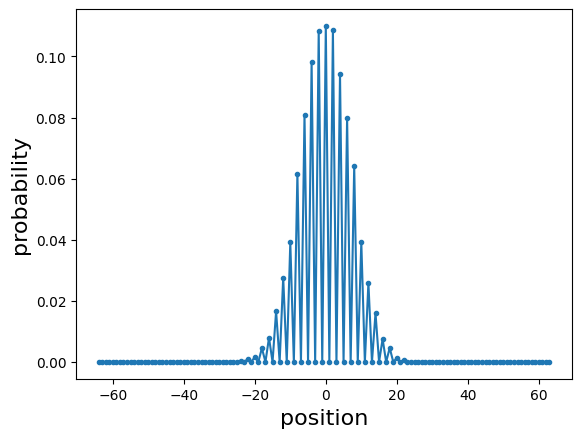

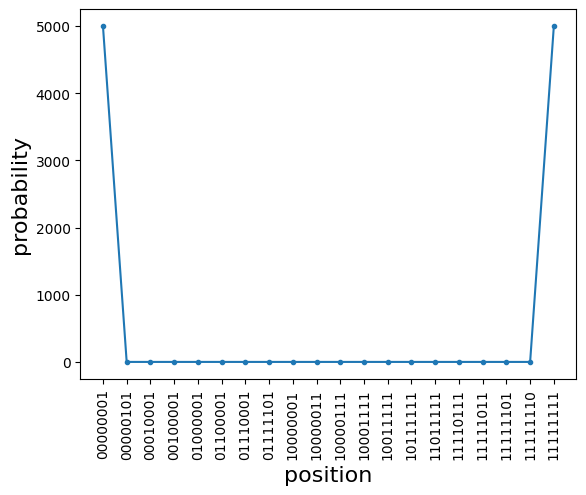

In [17]:
# classical
prob_classical = final_pos / NUM_SAMPLES
grid = (np.linspace(0, CIRCLE_SIZE - 1, CIRCLE_SIZE)).astype(int)
flipped_grid = np.append(
    grid[CIRCLE_SIZE // 2 : CIRCLE_SIZE] - CIRCLE_SIZE, grid[0 : CIRCLE_SIZE // 2]
)
flipped_prob_classical = np.append(
    prob_classical[CIRCLE_SIZE // 2 : CIRCLE_SIZE], prob_classical[0 : CIRCLE_SIZE // 2]
)

sorted_quantum_probs = dict(sorted(counts.items()))


plt.plot(flipped_grid, flipped_prob_classical, ".-")
plt.xlabel("position", fontsize=16)
plt.ylabel("probability", fontsize=16)
plt.show()

plt.plot(sorted_quantum_probs.keys(), sorted_quantum_probs.values(), ".-")
plt.xlabel("position", fontsize=16)
plt.ylabel("probability", fontsize=16)
plt.xticks(rotation='vertical')  # Rotate labels vertically
plt.show()

We can see a clear difference between the two distributions. The classical distribution is symmetric around the zero position, whereas the quantum example is asymmetric with a peak far from 0. This is a small example of the different behaviors of classical random walks and quantum walks. More details and examples can be found in Ref. [[1](#review)].

## How to Build a General Quantum Walk with Classiq

We define a quantum function for a discrete quantum walk. The arguments of the function are:
* `time`: an integer for the number of walking steps.
* `coin_flip_qfunc`: the quantum function for "flipping" the coin.
*  `walks_qfuncs`: a list of quantum functions for all possible transitions at a given point.
*  `coin_state`: the quantum state of the coin.

In [8]:
from classiq.qmod.symbolic import pi


@qfunc
def discrete_quantum_walk(
    time: CInt,
    coin_flip_qfunc: QCallable[QNum],
    walks_qfuncs: QCallableList,
    coin_state: QNum,
):

    power(
        time,
        lambda: (
            coin_flip_qfunc(coin_state),
            repeat(
                walks_qfuncs.len,
                lambda i: control(coin_state == i, lambda: walks_qfuncs[i]()),
            ),
        ),
    )

## Example: Symmetric Quantum Walk on a Circle

As a first example, we can consider the circle geometry from above, implemented with our generic definition. However, as opposed to the implementation above we take a different initial condition for the coin, $\frac{1}{\sqrt{2}}(|0\rangle +i |1\rangle)$ instead of $|0\rangle$. This state is a balanced initial condition for the coin (see Ref. [[1](#review)]) and can be prepared by applying an H gate followed by an S gate.

In [9]:
from classiq.execution import ExecutionPreferences

CIRCLE_SIZE = 2**7
NUM_SHOTS = 1e4


@qfunc
def main(t: CInt, x: Output[QNum]):

    coin = QBit("coin")
    allocate_num(floor(log(CIRCLE_SIZE, 2)), True, 0, x)
    allocate(1, coin)
    H(coin)
    S(coin)
    discrete_quantum_walk(
        t,
        lambda coin: H(coin),
        [
            lambda: quantum_step_clockwise(x),
            lambda: invert(lambda: quantum_step_clockwise(x)),
        ],
        coin,
    )


@cfunc
def cmain():
    save({"run1": sample({"t": 50})})


qmod = create_model(
    main,
    classical_execution_function=cmain,
    execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS),
)

Now that our model is defined we can synthesize, execute and plot the outcome probability:

Opening: https://platform.classiq.io/circuit/fed6430d-a969-460d-b3b0-0de498615514?version=0.59.0
Executing Quantum Circuit With...
8 Qubits And ...
425 Gates
Time Taken 0:00:00.102999
{'00000010': 5000, '11111111': 5000, '10000010': 0, '01111111': 0, '11000010': 0, '01000010': 0, '10111111': 0, '00111111': 0, '11101111': 0, '00001111': 0, '11110111': 0, '00000111': 0, '00100010': 0, '11011111': 0, '11100010': 0, '00000011': 0, '11111011': 0, '11111010': 0, '00011111': 0, '00001010': 0}


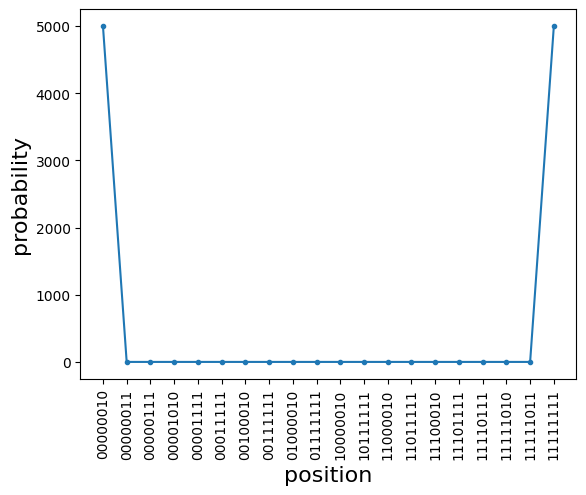

In [10]:
qprog = synthesize(qmod)
write_qmod(qmod, "quantum_walk_circle_balanced_coin")
show(qprog)
circuit = generateQiskitCircuit(qprog)

# Run the circuit and get results
result_sim = backend.run(circuit, repetitions=NUM_SAMPLES, topK=20)

counts = result_sim.get_counts(None)
print(counts)

sorted_quantum_probs = dict(sorted(counts.items()))

plt.plot(sorted_quantum_probs.keys(), sorted_quantum_probs.values(), ".-")
plt.xlabel("position", fontsize=16)
plt.ylabel("probability", fontsize=16)
plt.xticks(rotation='vertical')  # Rotate labels vertically
plt.show()

We can see that now the distribution is symmetric. Clearly, the distribution of a quantum walk on a circle depends on the initial condition for the coin. This is another example of the peculiar behavior of quantum walks, with respect to classical random walks.

## Technical Notes

### QFT modular adder

Below we explain the `quantum_step_clockwise` function defined for the quantum walk on a circle. The unitary matrix that represents walking on a circle operates as follows:
$$
U_{+}|i\rangle =
\left\{
\begin{array}{l l}
 |i+1\rangle & {\text{if  } } i\neq 2^{N-1}\\
 |0\rangle & {\text{if  } } i = 2^{N-1}
\end{array}
\right.
$$
In a matrix form this is simply the matrix
$$
U_+ = 
\begin{pmatrix}
	 0 & 1 & 0 & \cdots & 0 & 0 \\
	 0 & 0 & 1 & 0 & \cdots & 0 \\
	 0 & \ddots &\ddots & \ddots & \cdots & 0 \\
	 \vdots & \ddots & \ddots & \ddots& \ddots & \vdots \\
	 0 & \ddots & \ddots & 0& 0 & 1\\
	 1 & 0 & 0 & \cdots & 0 & 0
\end{pmatrix}.
$$
In Fourier space this matrix is diagonal, namely, the Fourier matrix $\mathcal{FT} $ diagonalizes it. Moreover, the diagonal entries forms a goemetric series:
$$
U_+  = \mathcal{FT} \cdot \begin{pmatrix}
	\alpha^0 &  0 & \cdots& \cdots  & 0 \\
	 0 & \alpha^1 & 0 &  \cdots & 0 \\
	 0 & 0 &\ddots & \cdots & 0 \\
	 0 & 0 &\cdots & \alpha^{2^N-2} & 0 \\
	 0 & \cdots & 0 & \cdots & \alpha^{2^N-1}
\end{pmatrix} \cdot \mathcal{FT}^{\dagger},
$$
with $\alpha=e^{2\pi i /2^N }$. We can implement both the $\mathcal{FT}$ matrix and the diagonal matrix efficiently on a quantum computer, the former by a QFT and the latter by applying a series of $N$ RZ rotations.

<a id='review'>[1]</a>: [Kempe, J. "Quantum random walks: an introductory overview." Contemporary Physics 44, 307 (2003)](https://arxiv.org/abs/quant-ph/0303081).

<a id='hypercube'>[2]</a>: [Kempe, J. "Discrete quantum walks hit exponentially faster." Probability theory and related fields 133, 215 (2005)](https://arxiv.org/abs/quant-ph/0205083).